In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance
import os

In [2]:
# Download dataset from KaggleHub
path = kagglehub.dataset_download("fedesoriano/california-housing-prices-data-extra-features")

print("Path to dataset files:", path)

# Check what files are inside
print(os.listdir(path))

Path to dataset files: /root/.cache/kagglehub/datasets/fedesoriano/california-housing-prices-data-extra-features/versions/1
['California_Houses.csv']


In [3]:
file_path = os.path.join(path, "California_Houses.csv")
df = pd.read_csv(file_path)
df.head()

,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
0,452600.0,8.3252,41,880,129,322,126,37.88,-122.23,9263.040773,556529.158342,735501.806984,67432.517001,21250.213767
1,358500.0,8.3014,21,7099,1106,2401,1138,37.86,-122.22,10225.733072,554279.850069,733236.884360,65049.908574,20880.600400
2,352100.0,7.2574,52,1467,190,496,177,37.85,-122.24,8259.085109,554610.717069,733525.682937,64867.289833,18811.487450
3,341300.0,5.6431,52,1274,235,558,219,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568
4,342200.0,3.8462,52,1627,280,565,259,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568


In [4]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Median_House_Value        20640 non-null  float64
 1   Median_Income             20640 non-null  float64
 2   Median_Age                20640 non-null  int64  
 3   Tot_Rooms                 20640 non-null  int64  
 4   Tot_Bedrooms              20640 non-null  int64  
 5   Population                20640 non-null  int64  
 6   Households                20640 non-null  int64  
 7   Latitude                  20640 non-null  float64
 8   Longitude                 20640 non-null  float64
 9   Distance_to_coast         20640 non-null  float64
 10  Distance_to_LA            20640 non-null  float64
 11  Distance_to_SanDiego      20640 non-null  float64
 12  Distance_to_SanJose       20640 non-null  float64
 13  Distance_to_SanFrancisco  20640 non-null  float64
dtypes: flo

Median_House_Value          0
Median_Income               0
Median_Age                  0
Tot_Rooms                   0
Tot_Bedrooms                0
Population                  0
Households                  0
Latitude                    0
Longitude                   0
Distance_to_coast           0
Distance_to_LA              0
Distance_to_SanDiego        0
Distance_to_SanJose         0
Distance_to_SanFrancisco    0
dtype: int64

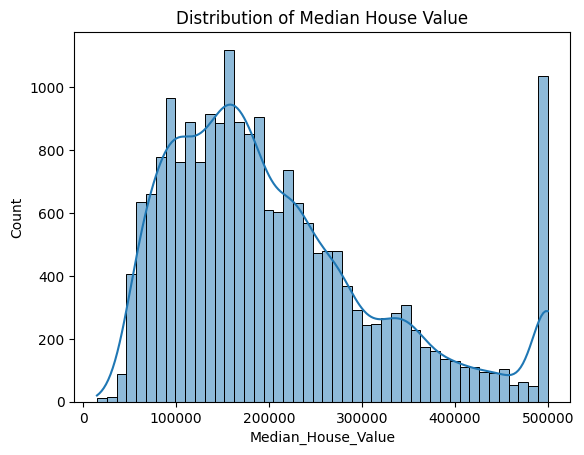

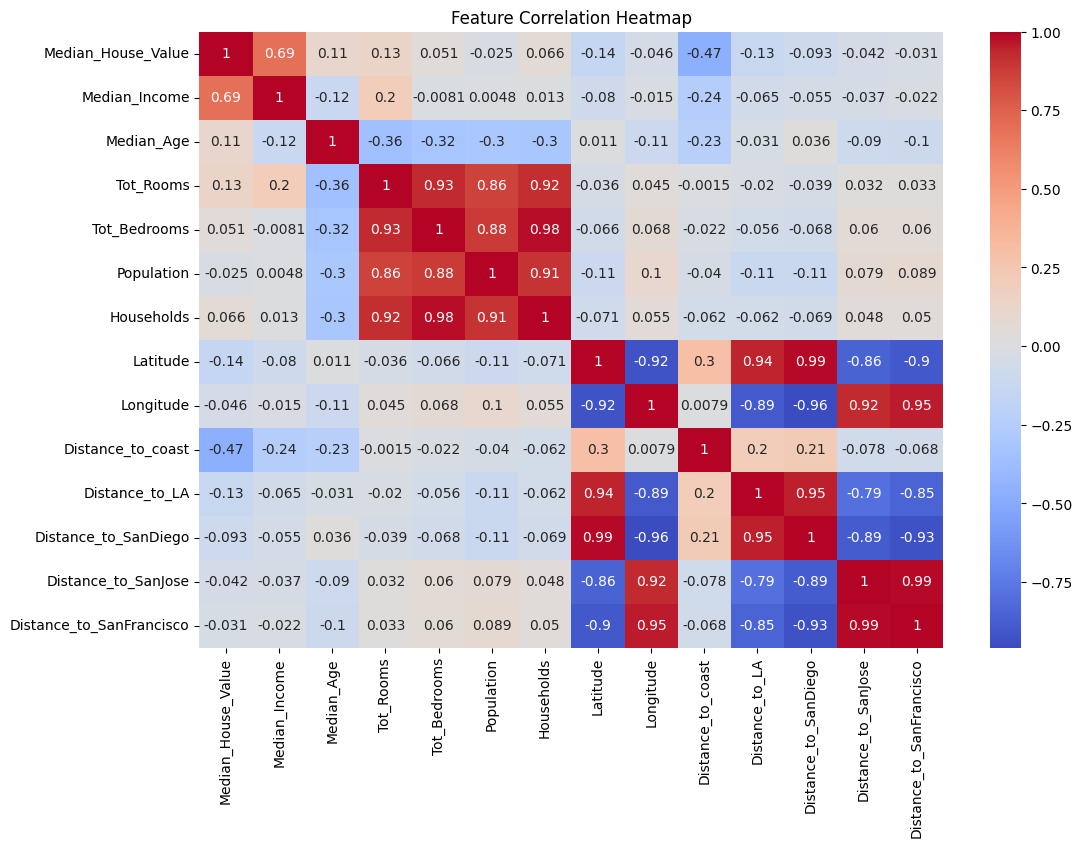

In [5]:
sns.histplot(df['Median_House_Value'], kde=True)
plt.title('Distribution of Median House Value')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title('Feature Correlation Heatmap')
plt.show()

In [6]:
X = df.drop('Median_House_Value', axis=1)
y = df['Median_House_Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Poniżej definiujemy różne konfiguracje modelu XGBoost, aby zbadać wpływ poszczególnych parametrów:

1. **Model bazowy** - punkt odniesienia z prostymi parametrami
2. **Grupa A** - modele różniące się tylko liczbą estymatorów (`n_estimators`)
3. **Grupa B** - modele różniące się tylko współczynnikiem uczenia (`learning_rate`)
4. **Grupa C** - modele różniące się tylko maksymalną głębokością drzewa (`max_depth`)

In [7]:
from tabulate import tabulate

base_model = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42}

# Group A: Varying n_estimators only
group_A = [
    {'n_estimators': 50,  'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42},
    {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42},
    {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42}
]

# Group B: Varying learning_rate only
group_B = [
    {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3, 'random_state': 42},
    {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'random_state': 42},
    {'n_estimators': 100, 'learning_rate': 0.3,  'max_depth': 3, 'random_state': 42}
]

# Group C: Varying max_depth only
group_C = [
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 2,  'random_state': 42},
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6,  'random_state': 42},
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10, 'random_state': 42}
]

# Combine all parameter sets
param_combinations = [base_model] + group_A + group_B + group_C

# Create model labels for better identification
model_labels = [
    "Model 1: Bazowy",  # Base model
    "Model 2: n_estimators=50",  # Group A
    "Model 3: n_estimators=200",
    "Model 4: n_estimators=500",
    "Model 5: learning_rate=0.01",  # Group B
    "Model 6: learning_rate=0.05",
    "Model 7: learning_rate=0.3",
    "Model 8: max_depth=2",  # Group C
    "Model 9: max_depth=6",
    "Model 10: max_depth=10"
]

results = []
trained_models = {}  # Dictionary to store trained models

# Train and evaluate models with different parameters
for i, params in enumerate(param_combinations):
    print(f"Training {model_labels[i]} with params: {params}")
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': model_labels[i],
        'Parameters': params,
        'RMSE': rmse,
        'R2 Score': r2
    })

    # Assign trained model to the global dictionary
    trained_models[model_labels[i]] = model

# Display results in a tabular format
print("\nWyniki porównania modeli:")
print(tabulate(
    [[res['Model'], res['RMSE'], res['R2 Score']] for res in results],
    headers=["Model", "RMSE", "R2 Score"],
    tablefmt="pretty"
))

Training Model 1: Bazowy with params: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42}
Training Model 2: n_estimators=50 with params: {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42}
Training Model 3: n_estimators=200 with params: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42}
Training Model 4: n_estimators=500 with params: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42}
Training Model 5: learning_rate=0.01 with params: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3, 'random_state': 42}
Training Model 6: learning_rate=0.05 with params: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'random_state': 42}
Training Model 7: learning_rate=0.3 with params: {'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 3, 'random_state': 42}
Training Model 8: max_depth=2 with params: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 2, 'rando

In [8]:
# Display results in a DataFrame for comparison
results_df = pd.DataFrame(results)

# Add a column for the changing parameter type (for easier analysis)
param_type = ['Bazowy'] + ['n_estimators']*3 + ['learning_rate']*3 + ['max_depth']*3
results_df['Parametr zmieniany'] = param_type

# Print full results table using tabulate
print("Wyniki porównania modeli:")
print(tabulate(
  results_df[["Model", "Parametr zmieniany", "RMSE", "R2 Score"]],
  headers="keys",
  tablefmt="pretty",
  showindex=False
))

Wyniki porównania modeli:
+-----------------------------+--------------------+--------------------+--------------------+
|            Model            | Parametr zmieniany |        RMSE        |      R2 Score      |
+-----------------------------+--------------------+--------------------+--------------------+
|       Model 1: Bazowy       |       Bazowy       | 53981.187836250574 | 0.7776290693517458 |
|  Model 2: n_estimators=50   |    n_estimators    | 58994.42238435171  | 0.7344079649747723 |
|  Model 3: n_estimators=200  |    n_estimators    | 50261.95343422279  | 0.8072156094034665 |
|  Model 4: n_estimators=500  |    n_estimators    | 47050.038642927706 | 0.8310675389852196 |
| Model 5: learning_rate=0.01 |   learning_rate    | 80240.83622579547  | 0.5086578384972505 |
| Model 6: learning_rate=0.05 |   learning_rate    | 59311.582683355795 | 0.7315445865513719 |
| Model 7: learning_rate=0.3  |   learning_rate    |  49573.7652212581  | 0.8124586874006725 |
|    Model 8: max_depth=

In [9]:
# Analiza wpływu n_estimators
n_est_models = results_df[results_df['Parametr zmieniany'] == 'n_estimators'].copy()
n_est_models = pd.concat([results_df[results_df['Parametr zmieniany'] == 'Bazowy'], n_est_models])
print("\nWpływ parametru n_estimators:")
print(tabulate(n_est_models[["Model", "RMSE", "R2 Score"]], headers="keys", tablefmt="pretty", showindex=False))

# Analiza wpływu learning_rate
lr_models = results_df[results_df['Parametr zmieniany'] == 'learning_rate'].copy()
lr_models = pd.concat([results_df[results_df['Parametr zmieniany'] == 'Bazowy'], lr_models])
print("\nWpływ parametru learning_rate:")
print(tabulate(lr_models[["Model", "RMSE", "R2 Score"]], headers="keys", tablefmt="pretty", showindex=False))

# Analiza wpływu max_depth
depth_models = results_df[results_df['Parametr zmieniany'] == 'max_depth'].copy()
depth_models = pd.concat([results_df[results_df['Parametr zmieniany'] == 'Bazowy'], depth_models])
print("\nWpływ parametru max_depth:")
print(tabulate(depth_models[["Model", "RMSE", "R2 Score"]], headers="keys", tablefmt="pretty", showindex=False))



Wpływ parametru n_estimators:
+---------------------------+--------------------+--------------------+
|           Model           |        RMSE        |      R2 Score      |
+---------------------------+--------------------+--------------------+
|      Model 1: Bazowy      | 53981.187836250574 | 0.7776290693517458 |
| Model 2: n_estimators=50  | 58994.42238435171  | 0.7344079649747723 |
| Model 3: n_estimators=200 | 50261.95343422279  | 0.8072156094034665 |
| Model 4: n_estimators=500 | 47050.038642927706 | 0.8310675389852196 |
+---------------------------+--------------------+--------------------+

Wpływ parametru learning_rate:
+-----------------------------+--------------------+--------------------+
|            Model            |        RMSE        |      R2 Score      |
+-----------------------------+--------------------+--------------------+
|       Model 1: Bazowy       | 53981.187836250574 | 0.7776290693517458 |
| Model 5: learning_rate=0.01 | 80240.83622579547  | 0.5086578384

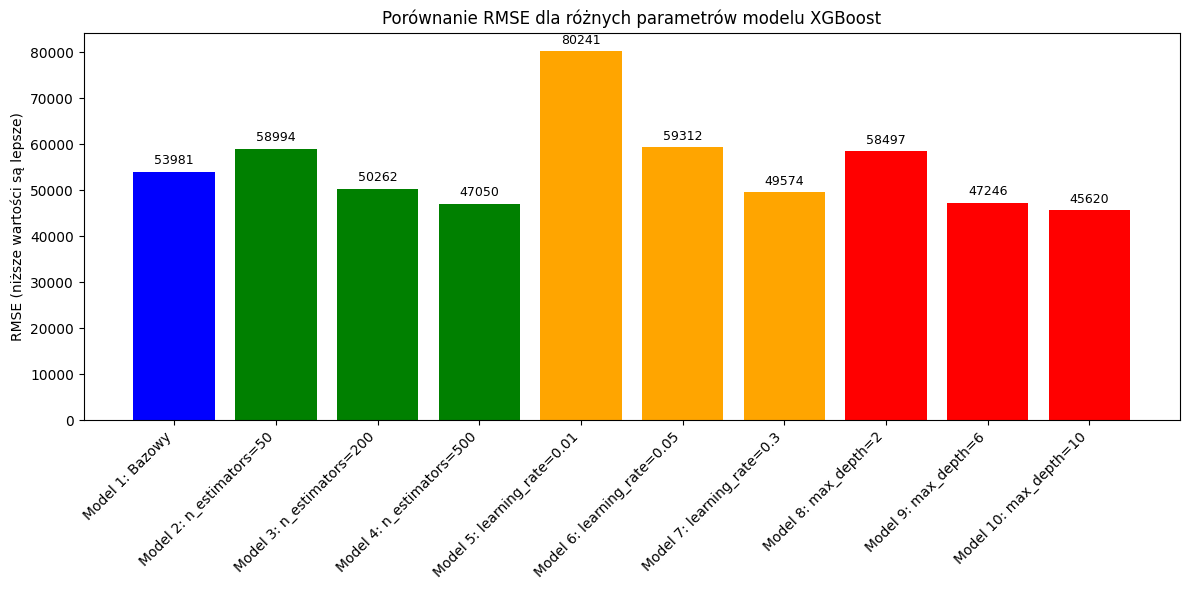


Porównanie RMSE dla różnych parametrów modelu:
+-----------------------------+--------------------+
|            Model            |        RMSE        |
+-----------------------------+--------------------+
|       Model 1: Bazowy       | 53981.187836250574 |
|  Model 2: n_estimators=50   | 58994.42238435171  |
|  Model 3: n_estimators=200  | 50261.95343422279  |
|  Model 4: n_estimators=500  | 47050.038642927706 |
| Model 5: learning_rate=0.01 | 80240.83622579547  |
| Model 6: learning_rate=0.05 | 59311.582683355795 |
| Model 7: learning_rate=0.3  |  49573.7652212581  |
|    Model 8: max_depth=2     | 58496.66258973827  |
|    Model 9: max_depth=6     | 47245.93605725825  |
|   Model 10: max_depth=10    | 45620.06930862379  |
+-----------------------------+--------------------+


In [10]:
# Visualize RMSE for all models
plt.figure(figsize=(12, 6))
bar = plt.bar(results_df['Model'], results_df['RMSE'], color=['blue'] + ['green']*3 + ['orange']*3 + ['red']*3)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE (niższe wartości są lepsze)')
plt.title('Porównanie RMSE dla różnych parametrów modelu XGBoost')

# Add value labels on top of bars
for b in bar:
    plt.text(b.get_x() + b.get_width()/2, b.get_height() + 1000,
             f'{b.get_height():.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Display results using tabulate
print("\nPorównanie RMSE dla różnych parametrów modelu:")
print(tabulate(
    results_df[["Model", "RMSE"]],
    headers="keys",
    tablefmt="pretty",
    showindex=False
))

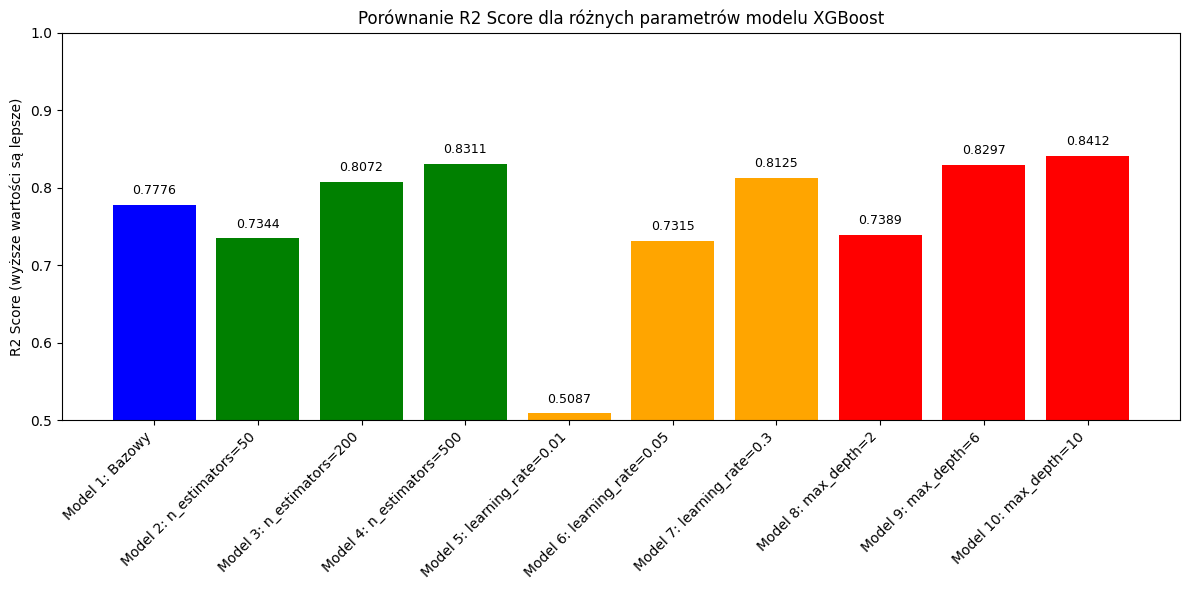


Porównanie R2 Score dla różnych parametrów modelu:
+-----------------------------+--------------------+
|            Model            |      R2 Score      |
+-----------------------------+--------------------+
|       Model 1: Bazowy       | 0.7776290693517458 |
|  Model 2: n_estimators=50   | 0.7344079649747723 |
|  Model 3: n_estimators=200  | 0.8072156094034665 |
|  Model 4: n_estimators=500  | 0.8310675389852196 |
| Model 5: learning_rate=0.01 | 0.5086578384972505 |
| Model 6: learning_rate=0.05 | 0.7315445865513719 |
| Model 7: learning_rate=0.3  | 0.8124586874006725 |
|    Model 8: max_depth=2     | 0.7388708723034538 |
|    Model 9: max_depth=6     | 0.8296578769688358 |
|   Model 10: max_depth=10    | 0.8411800622338959 |
+-----------------------------+--------------------+


In [11]:
# Visualize R2 Score for all models
plt.figure(figsize=(12, 6))
bar = plt.bar(results_df['Model'], results_df['R2 Score'], color=['blue'] + ['green']*3 + ['orange']*3 + ['red']*3)
plt.xticks(rotation=45, ha='right')
plt.ylabel('R2 Score (wyższe wartości są lepsze)')
plt.title('Porównanie R2 Score dla różnych parametrów modelu XGBoost')
plt.ylim(0.5, 1.0)  # Set y-axis limit to better visualize differences

# Add value labels on top of bars
for b in bar:
    plt.text(b.get_x() + b.get_width()/2, b.get_height() + 0.01,
             f'{b.get_height():.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Display results using tabulate
print("\nPorównanie R2 Score dla różnych parametrów modelu:")
print(tabulate(
    results_df[["Model", "R2 Score"]],
    headers="keys",
    tablefmt="pretty",
    showindex=False
))

## Ważność cech dla wszystkich modeli

Wizualizacja ważności cech dla wszystkich modeli, aby zobaczyć jak różne parametry wpływają na to, które cechy model uważa za najważniejsze.


Ważność cech dla Model 1: Bazowy:
+--------------------------+------------+
|         Feature          | Importance |
+--------------------------+------------+
|      Median_Income       |   103.0    |
|    Distance_to_coast     |    99.0    |
|         Latitude         |    72.0    |
|        Longitude         |    62.0    |
|      Distance_to_LA      |    60.0    |
|        Population        |    59.0    |
|   Distance_to_SanJose    |    50.0    |
|       Tot_Bedrooms       |    49.0    |
|        Tot_Rooms         |    40.0    |
|        Median_Age        |    36.0    |
|   Distance_to_SanDiego   |    27.0    |
| Distance_to_SanFrancisco |    22.0    |
|        Households        |    20.0    |
+--------------------------+------------+

Ważność cech dla Model 2: n_estimators=50:
+--------------------------+------------+
|         Feature          | Importance |
+--------------------------+------------+
|      Median_Income       |    73.0    |
|    Distance_to_coast     |    69.0   

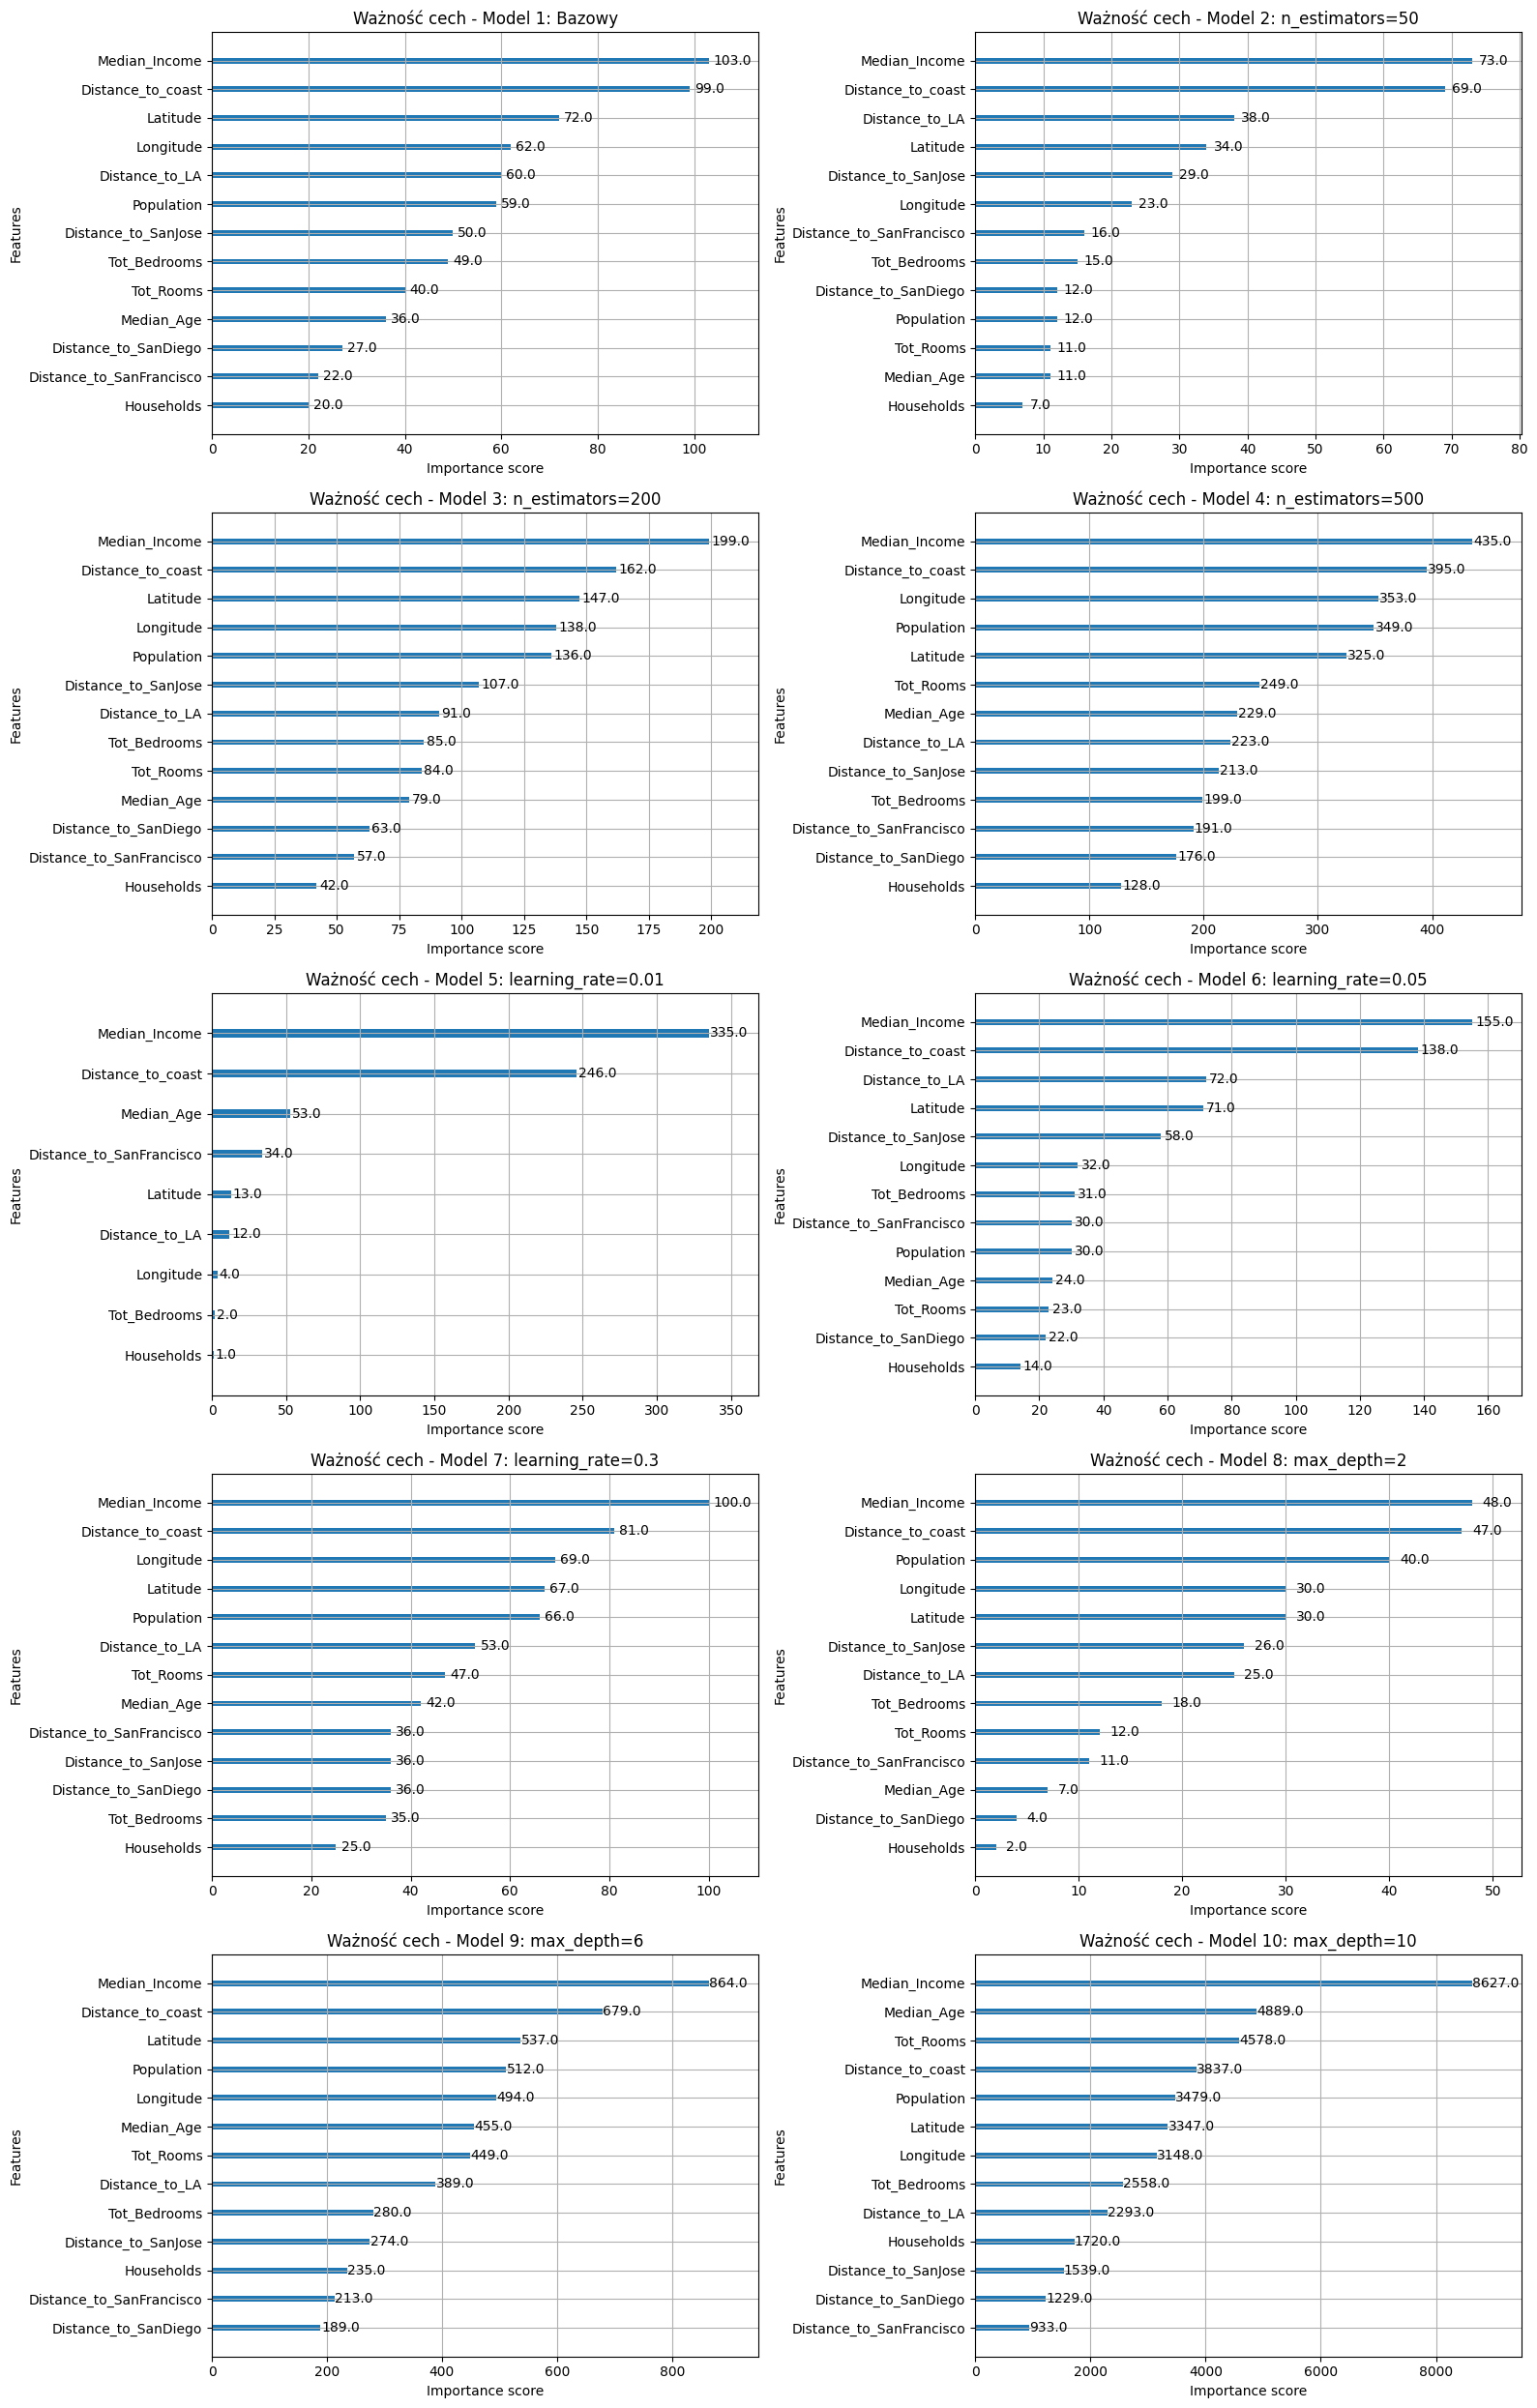

In [12]:
# Create a figure with subplots for all models
n_models = len(param_combinations)
fig, axes = plt.subplots(nrows=(n_models+1)//2, ncols=2, figsize=(16, 5*((n_models+1)//2)))
axes = axes.flatten() if n_models > 1 else [axes]

# Train each model and plot feature importance
for i, label in enumerate(model_labels):
    model = trained_models[label]

    # Plot feature importance on the corresponding subplot
    plot_importance(model, ax=axes[i], importance_type='weight', title=f'Ważność cech - {label}')

    # Extract feature importance data
    importance = model.get_booster().get_score(importance_type='weight')
    importance_data = sorted(importance.items(), key=lambda x: x[1], reverse=True)

    # Display feature importance data using tabulate
    print(f"\nWażność cech dla {label}:")
    print(tabulate(importance_data, headers=["Feature", "Importance"], tablefmt="pretty"))

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()